# Lake tables - EFAS
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 21-10-2024<br>

**Introduction:**<br>


**To do:**

In [3]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from tqdm.notebook import tqdm
from shapely.geometry import Point
from pathlib import Path

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from lisfloodreservoirs.utils.utils import filter_domain, filter_reservoirs, find_connections, remove_duplicates, upstream_pixel, downstream_pixel
from lisfloodreservoirs.utils.plots import plot_reservoir_map

In [4]:
def scientific_format(num):
    if num == 0:
        return '0'
    else:
        exponent = int(np.log10(abs(num)))
        prefix = num / 10**(exponent - 1)
        suffix = '⁰¹²³⁴⁵⁶⁷⁸⁹'[exponent]  # Unicode superscript digits for 0 to 9
        return f"{prefix:.0f}{suffix}"

In [5]:
def compare_attributes(df, thr, vmin, vmax, **kwargs):
    """Pair plot comparing the attribute values in different data sources
    
    Parameters:
    -----------
    df: pandas.DataFrame
        Values of an attributes in different data sources (columns)
    thr: float
        Minimum value of the attribute used in the selection
    vmin: float
        Minimum attribute value to be plotted
    vmax: float
        Maximum attribute value to be plotted
    """
    
    figsize = kwargs.get('figsize', (4, 4))
    
    cols = df.columns
    ncols = len(cols) - 1
    
    fig, ax = plt.subplots(ncols=ncols, nrows=ncols, figsize=(ncols * figsize[0], ncols * figsize[1]), sharex=True, sharey=True)

    for j, colx in enumerate(cols[:-1]):
        for i, coly in enumerate(cols[1:]):
            if j > i:
                ax[i, j].axis('off')
                continue
            ax[i, j].plot([vmin, vmax], [vmin, vmax], c='k', lw=.5, zorder=0)
            ax[i, j].vlines(thr, vmin, thr, color='k', ls='--', lw=.5, zorder=0)
            ax[i, j].hlines(thr, vmin, thr, color='k', ls='--', lw=.5, zorder=0)
            ax[i, j].scatter(df[colx], df[coly], s=10, alpha=.5)
            ax[i, j].set_xscale('log')
            ax[i, j].set_yscale('log')
            if j == 0:
                ax[i, j].set_ylabel(coly)
            if i == 2:
                ax[i, j].set_xlabel(colx)

            ax[i, j].set(
                xlim=(vmin, vmax),
                ylim=(vmin, vmax),
            );
    
    if 'title' in kwargs:
        ax[0, 1].set_title(kwargs['title']);

## Configuration

In [6]:
# paths
PATH_EFAS5 = Path('Z:/nahaUsers/casadje/EFASv5')
PATH_DATASETS = Path('Z:/nahaUsers/casadje/datasets/')
PATH_EFAS6 = PATH_DATASETS / 'lakes' / 'EFASv6' #Path('../results/reservoirs/selection/EFAS/')

# minimum storage capacity included in EFAS
MIN_VOLUME = 10 # hm³
MIN_AREA = 5 # km²
MIN_CATCHMENT = 50 # km²
# MIN_DOR = 30 # days

## DATA

### EFAS6

In [7]:
# import shapefile
efas6 = gpd.read_file('Z:/H07_Global/GloFAS/data/reservoir and lakes EFAS Glofas 2024/LakesEfasV6.shp')

# keep only selected lakes
efas6 = efas6[efas6.checked != 3]

# remove IDs equal to 0
for col in ['LakID', 'Hylak_id', 'GLWD_ID']:
    efas6[col] = efas6[col].astype('Int64')
    efas6.loc[efas6[col] == 0, col] = np.nan

# convert 0 to NaN
for col in ['AREA_KM2', 'LON_ORG', 'LAT_ORG', 'CATCH_AREA', 'AREA']:
    efas6.loc[efas6[col] == 0, col] = np.nan
    
print('{0} lakes in EFAS6'.format(efas6.shape[0]))
print('\t* {0} are not in HydroLakes'.format(efas6.Hylak_id.isnull().sum()))
print('\t* {0} were not in EFAS5'.format(efas6.LakID.isnull().sum()))

216 lakes in EFAS6
	* 1 are not in HydroLakes
	* 95 were not in EFAS5


In [8]:
efas6.isnull().sum()

LakID          95
SOURCE         96
TYPE           97
COUNTRY        24
LAKE_NAME      94
AREA_KM2       97
LON_ORG        97
LAT_ORG        97
LISFLOODX       0
LISFLOODY       0
CATCH_AREA     97
AREA           97
Hylak_id        1
Comment       192
GLWD_ID       216
priority        0
checked         0
geometry        0
dtype: int64

### EFAS5

In [9]:
efas5 = gpd.read_file(PATH_EFAS6 / 'efasv5_lakes.shp').set_index('LakID')
efas5.rename(columns={'A': 'ALPHA'}, inplace=True)

print('{0} lakes in EFAS5'.format(efas5.shape[0]))
print('\t* {0} removed in EFAS6'.format(len(efas5.index.difference(efas6.LakID))))

204 lakes in EFAS5
	* 83 removed in EFAS6


In [10]:
efas5.columns

Index(['TAG', 'SOURCE', 'TYPE', 'COUNTRY', 'LAKE_NAME', 'AREA_KM2', 'LON_ORG',
       'LAT_ORG', 'LISFLOODX', 'LISFLOODY', 'CATCH_AREA', 'ALPHA', 'AREA',
       'AVINFLOW', 'Hylak_id', 'HYLAK_NAME', 'HYLAK_TYPE', 'HYLAK_AREA',
       'HYLAK_VOL', 'HYLAK_DEPT', 'HYLAK_DIS', 'HYLAK_DOR', 'HYLAK_CAT',
       'Comment', 'GLWD_ID', 'geometry'],
      dtype='object')

### HydroLakes

In [11]:
hylak = gpd.read_file('Z:/nahaUsers/casadje/datasets/lakes/HydroLAKES/LakeATLAS_v10_shp/LakeATLAS_v10_pnt_east.shp').set_index('Hylak_id')

In [12]:
hylak_ids = set(efas6.loc[efas6.Hylak_id.notnull(), 'Hylak_id'])
hylak = hylak.loc[hylak_ids]

In [13]:
# hylak = gpd.read_file(PATH_EFAS6 / 'hydrolakes_pnt.shp').set_index('Hylak_id')

print('{0} lakes in HydroLakes'.format(hylak.shape[0]))
print('\t* {0} in EFAS6'.format(len(hylak.index.intersection(efas6.Hylak_id))))

213 lakes in HydroLakes
	* 213 in EFAS6


In [14]:
# # connection between Hylak and ID
# map_hylak_ID = {hylak_id: ID for ID, hylak_id in zip(efas6.index, efas6.Hylak_id) if not pd.isna(hylak_id)}
# hylak['ID'] = hylak.Hylak_id.map(map_hylak_ID).astype('Int64')
# hylak.set_index('Hylak_id', drop=True, inplace=True)

# print(hylak.shape)

## Attributes

### $\alpha$: channel width

In [49]:
# load EFAS static map
path = Path('Z:/nahaUsers/grimast/EFAS_1arcminmaps_JRC_catalogue_UPLOAD/v1.1.2/Catchments_morphology_and_river_network')
chanbw = rxr.open_rasterio(path / 'chanbw_European_01min.nc').squeeze(dim='band')

uparea = rxr.open_rasterio(path / 'upArea_European_01min.nc').squeeze(dim='band')

In [50]:
alpha = pd.DataFrame(index=efas6.index, columns=['EFAS5', 'CHANBW', 'algorithm'])

In [51]:
# extract channel width from map
alpha['CHANBW'] = pd.Series({ID: chanbw.sel(x=row.LISFLOODX, y=row.LISFLOODY, method='nearest').item() for ID, row in efas6.iterrows()})
# alpha.name = 'alpha'

In [52]:
# extract alpha values used in EFAS5
for ID, LakID in zip(efas6.index, efas6.LakID):
    if pd.isna(LakID):
        continue
    alpha.loc[ID, 'EFAS5'] = efas5.loc[LakID, 'ALPHA']

***
For each lake, I will extract the width of the bottom of the channel from the static map _chanbw.nc_. The value extracted is very sensitive to the exact location of the lake in the EFAS grid. If the lake is located in a pixel that is considered as lake in MERIT, the value will be large. For that reason, I will extract the values from one pixel upstream and 2 pixels downstream.

In [82]:
def upstream_pixel(lat: float, lon: float, upArea: xr.DataArray) -> tuple:
    """This function finds the upstream coordinates of a given point
    
    Parameteres:
    ------------
    lat: float
        latitude of the input point
    lon: float
        longitued of the input point
    upArea: xarray.DataArray
        map of upstream area
        
    Returns:
    --------
    lat: float
        latitude of the inmediate upstream pixel
    lon: float
        longitued of the inmediate upstream pixel
    """
    
    # Determine coordinate system
    lat_coord = 'lat' if 'lat' in upArea.coords else 'y'
    lon_coord = 'lon' if 'lon' in upArea.coords else 'x'
    
    try:
        # upstream area of the input coordinates
        area = upArea.sel({lat_coord: lat, lon_coord: lon}, method='nearest').values
        
        # spatial resolution of the input map
        resolution = np.mean(np.diff(upArea[lon_coord].values))
        
        # Define window around the input pixel
        window = np.array([-1.5 * resolution, 1.5 * resolution])
        upArea_window = upArea.sel({lat_coord: slice(lat + window[1], lat + window[0]),
                                    lon_coord: slice(lon + window[0], lon + window[1])})
    
        # remove pixels with area equal or greater than the input pixel
        mask = upArea_window.where(upArea_window < area, np.nan)
        
        # Find the pixel with the smallest upstream area
        upstream_pixel = mask.where(mask == mask.min(), drop=True)
    
        return (upstream_pixel[lat_coord].data[0].round(4),
                upstream_pixel[lon_coord].data[0].round(4))
                
    except Exception as e:
        logger.error(f"Failed to find upstream pixel: {e}")
        return None, None

In [71]:
def downstream_pixel(lat: float, lon: float, upArea: xr.DataArray) -> tuple:
    """
    This function finds the downstream pixel coordinates of a given point.
    
    Parameters:
    -----------
    lat: float
        Latitude of the input point.
    lon: float
        Longitude of the input point.
    upArea: xarray.DataArray
        Map of upstream area.
        
    Returns:
    --------
    tuple:
        Latitude and longitude of the immediate downstream pixel,
        or (None, None) if not found.
    """
    
    # Determine coordinate system
    lat_coord = 'lat' if 'lat' in upArea.coords else 'y'
    lon_coord = 'lon' if 'lon' in upArea.coords else 'x'
    
    try:
        # upstream area of the input coordinates
        area = upArea.sel({lat_coord: lat, lon_coord: lon}, method='nearest').values
        
        # spatial resolution of the input map
        resolution = np.mean(np.diff(upArea[lon_coord].values))
        
        # Define window around the input pixel
        window = np.array([-1.5 * resolution, 1.5 * resolution])
        upArea_window = upArea.sel({lat_coord: slice(lat + window[1], lat + window[0]),
                                    lon_coord: slice(lon + window[0], lon + window[1])})
        
        # Mask out pixels with area less than or equal to the input pixel
        mask = upArea_window.where(upArea_window > area, drop=True)
        
        # Find the pixel with the smallest upstream area
        downstream_pixel = mask.where(mask == mask.min(), drop=True)
        
        return (downstream_pixel[lat_coord].data[0].round(4),
                downstream_pixel[lon_coord].data[0].round(4))
                
    except Exception as e:
        logger.error(f"Failed to find downstream pixel: {e}")
        return None, None

In [102]:
def channel_width(chanbw, uparea, x, y):
    """
    """
    
    xs = np.array([x])
    ys = np.array([y])
    
    # coordinates of the two pixels upstream and downstream
    i = 0
    while i < 2:
        try:
            y_up, x_up = upstream_pixel(ys[0], xs[0], uparea)
            xs = np.hstack([x_up, xs])
            ys = np.hstack([y_up, ys])
        except:
            break
        i += 1
        
    # coordinates of the two pixels downstream
    i = 0
    while i < 2:
        try:
            y_down, x_down = downstream_pixel(ys[-1], xs[-1], uparea)
            xs = np.hstack([xs, x_down])
            ys = np.hstack([ys, y_down])
        except:
            break
        i += 1
        
    # extract channel width
    width = np.array([chanbw.sel(x=x, y=y, method='nearest').item() for x, y in zip(xs, ys)])

    # keep the width of the pixel with the largest difference with respect to the pixel upstream
    idx = np.argmin(width[1:] - width[:-1]) + 1
    return width[idx]

In [103]:
x, y

(31.1749999999, 46.6583333334)

In [104]:
channel_width(chanbw, uparea, x, y)

16.875

In [94]:
chanbw

<xarray.DataArray 'Band1' (y: 2970, x: 4530)>
[13454100 values with dtype=float32]
Coordinates:
    band     int32 1
  * x        (x) float64 -25.24 -25.23 -25.21 -25.19 ... 50.19 50.21 50.22 50.24
  * y        (y) float64 72.24 72.23 72.21 72.19 ... 22.81 22.79 22.77 22.76
    crs      int32 0
Attributes:
    lat#axis:                   Y
    lat#long_name:              latitude
    lat#standard_name:          latitude
    lat#units:                  degrees_north
    lat#_FillValue:             nan
    lon#axis:                   X
    lon#long_name:              longitude
    lon#standard_name:          longitude
    lon#units:                  degrees_east
    lon#_FillValue:             nan
    CDI:                        Climate Data Interface version 1.9.8 (https:/...
    CDO:                        Climate Data Operators version 1.9.8 (https:/...
    Conventions:                CF-1.5
    GDAL:                       GDAL 3.0.4, released 2020/01/28
    GDAL_AREA_OR_POINT:         Area
    history:                    Sun Dec 13 10:29:42 2020: cdo setmissval,-999...
    history_of_appended_files:  Sun Dec 13 10:29:42 2020: Appended file /perm...
    NCO:                        netCDF Operators version 4.9.2 (Homepage = ht...
    long_name:                  GDAL Band Number 1
    missing_value:              -999999
    STATISTICS_MAXIMUM:         154056.84375
    STATISTICS_MEAN:            37.946524491408
    STATISTICS_MINIMUM:         0
    STATISTICS_STDDEV:          860.80091135961
    _FillValue:                 -999999.0
    scale_factor:               1.0
    add_offset:                 0.0

In [ ]:
ID

In [105]:
for ID, row in efas6.iterrows():
    try:
        alpha.loc[ID, 'algorithm'] = channel_width(chanbw, uparea, row.LISFLOODX, row.LISFLOODY)
    except:
        print(ID)

In [55]:
efas6.loc[243, ['LakID', 'Hylak_id']]

LakID       <NA>
Hylak_id    1253
Name: 243, dtype: object

In [97]:
x, y = efas6.loc[243, ['LISFLOODX', 'LISFLOODY']]

In [99]:
width = channel_width(chanbw, uparea, x, y)

width

array([7.55845942e-03, 7.56076258e-03, 3.58378235e+02, 7.56076258e-03,
       7.55845942e-03])

In [100]:
width

array([7.55845942e-03, 7.56076258e-03, 3.58378235e+02, 7.56076258e-03,
       7.55845942e-03])

In [63]:
# coordinates of the two pixels upstream
y_u1, x_u1 = upstream_pixel(y, x, uparea)
y_u2, x_u2 = upstream_pixel(y_u1, x_u1, uparea)

# coordinates of the tow pixels downstream
y_d1, x_d1 = downstream_pixel(y, x, uparea)
y_d2, x_d2 = downstream_pixel(y_d1, x_d1, uparea)

No downstream pixel was found


In [64]:
# extract channel width in the 5 pixels
xs = [x_u2, x_u1, x, x_d1, x_d2]
ys = [y_u2, y_u1, y, y_d1, y_d2]
width = np.array([chanbw.sel(x=xi, y=yi, method='nearest').item() for xi, yi in zip(xs, ys)])

KeyError: nan

In [ ]:
width

In [46]:
# keep the width of the pixel with the largest difference with respect to the pixel upstream
idx = np.argmin(width[1:] - width[:-1]) + 1
width[idx]

0.0

In [61]:
chanbw.sel(x=x, y=y, method='nearest').item()

0.0

In [60]:
alpha.loc[243]

EFAS5               NaN
CHANBW       358.378235
algorithm           NaN
Name: 243, dtype: object

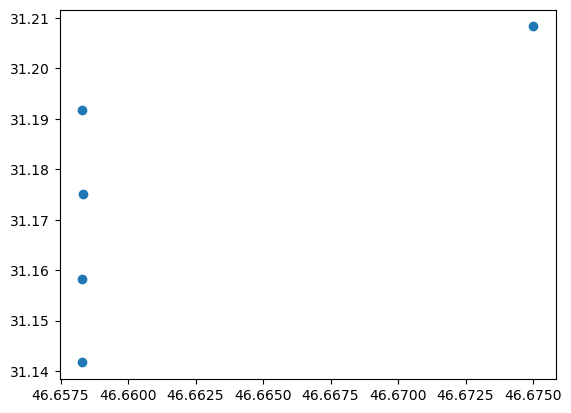

In [47]:
# plt.imshow(chanbw)
plt.scatter(xs, ys)
# plt.xlim(np.min(xs), np.max(xs))
# plt.ylim(np.min(ys), np.max(ys));

In [ ]:
plat.scatter(x, y)

In [ ]:
w

In [ ]:
# upstream area of the input coordinates
area = uparea.sel(y=y, x=x, method='nearest').values

# spatial resolution of the input map
resolution = np.mean(np.diff(uparea.x.values))

# window around the input pixel
window = np.array([-1.5 * resolution, 1.5 * resolution])
upArea_ = uparea.sel(y=slice(*window[::-1] + y)).sel(x=slice(*window + x))

# remove pixels with area equal or smaller than the input pixel
mask = upArea_.where(upArea_ > area, np.nan)

# from the remaining, find pixel with the smallest upstream area
pixel = upArea_.where(upArea_ == mask.min(), drop=True)

In [ ]:
{ID: channel_width(chanbw, uparea, row.LISFLOODX, row.LISFLOODY) for ID, row in efas6.iterrows()}

In [ ]:
for i, (ID, row) in enumerate(efas6.iterrows()):
    # if row.LakID == 576:
    if i == 0:
        break

In [ ]:
row

In [ ]:
plt.plot(width)

In [ ]:
    pd.Series({ID: chanbw.sel(x=row.LISFLOODX, y=row.LISFLOODY, method='nearest').item() for ID, row in efas6.iterrows()})

In [ ]:
pd.Series({ID: chanbw.sel(x=row.LISFLOODX, y=row.LISFLOODY, method='nearest').item() for ID, row in efas6.iterrows()})

***

#### Comparison

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))

vmin, vmax = -100, 4000
ax.plot([vmin, vmax], [vmin, vmax], c='k', lw=.5, zorder=0)
ax.scatter(alpha.EFAS5, alpha.CHANBW, s=10, alpha=.5)
ax.set(
    xlim=(vmin, vmax),
    xlabel='EFAS 5',
    ylim=(vmin, vmax),
    ylabel='chanbw',
    title=r'$\alpha$'
);

In [ ]:
efas6.loc[178, ['LakID', 'Hylak_id']]

In [ ]:
alpha['PCT_ERROR'] = abs(alpha.EFAS5 - alpha.CHANBW) / alpha.EFAS5 * 100

alpha[alpha.PCT_ERROR > 50].sort_values('PCT_ERROR', ascending=False)

In [ ]:
alpha.CHANBW.idxmax()

In [ ]:
alpha.loc[95]

In [ ]:
efas6.loc[95]

### Area

In [ ]:
area = pd.DataFrame(index=efas6.index, columns=['EFAS5', 'HYLAK'])

In [ ]:
# extract alpha values used in EFAS5
for ID, LakID, Hylak_id in zip(efas6.index, efas6.LakID, efas6.Hylak_id):
    if not pd.isna(LakID):
        try:
            area.loc[ID, 'EFAS5'] = efas5.loc[LakID, 'AREA_KM2']
        except:
            print('EFAS ID:', LakID)
    if not pd.isna(Hylak_id):
        try:
            area.loc[ID, 'HYLAK'] = hylak.loc[Hylak_id, 'Lake_area']
        except:
            print('Hylak ID:', Hylak_id)

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
vmin, vmax = 1, 21000
ax.plot([vmin, vmax], [vmin, vmax], c='k', lw=.5, zorder=0)
ax.scatter(area.EFAS5, area.HYLAK, s=10, alpha=.5)
ax.set(
    xlim=(vmin, vmax),
    xlabel='EFAS 5',
    ylim=(vmin, vmax),
    ylabel='HydroLakes',
    title=r'area (km²)'
);

ax.set_xscale('log')
ax.set_yscale('log');

In [ ]:
area['PCT_ERROR'] = abs(area.EFAS5 - area.HYLAK) / area.EFAS5 * 100

In [ ]:
efas6[efas6.Hylak_id == 1110]

In [ ]:
efas6.loc[131]

In [ ]:
area[area.PCT_ERROR > 20].sort_values('PCT_ERROR', ascending=False)

In [ ]:
hylak.Lake_area

In [ ]:
1054 in hylak.index

In [ ]:
hylak.columns

***

### Static map

In [ ]:
# load the upstream area map
uparea = rxr.open_rasterio(PATH_EFAS / 'static_maps' / 'upArea_European_01min.nc').squeeze(dim='band')
uparea = uparea.where(uparea != -999999, np.nan)

# load the domain
domain = rxr.open_rasterio(PATH_EFAS / 'static_maps' / 'domain_area_European_01min.nc').squeeze(dim='band')
lon_min, lat_min, lon_max, lat_max = np.round(domain.rio.bounds(), 6)
efas_cellsize = np.mean(np.diff(domain.x)) # degrees

### Reservoirs

In [ ]:
# reservoirs in EFASv5
efas_res = gpd.read_file(PATH_OUT.parent.parent / 'reservoirs' / 'EFASv6' / 'EFAS5' / 'efas5_reservoirs.shp')
efas_res.set_index('ResID', drop=True, inplace=True)
efas_res = efas_res[efas_res.GRAND_ID.notnull()]
efas_res.GRAND_ID = efas_res.GRAND_ID.astype(int)

In [ ]:
# reservoirs to be added in EFASv6
grand_to_add = gpd.read_file(PATH_OUT.parent.parent / 'reservoirs' / 'EFASv6' / 'GRanD' / 'grand_to_add.shp')
grand_to_add.set_index('GRAND_ID', drop=True, inplace=True)

### Lakes

#### Raster

In [ ]:
efas_raster = xr.open_dataset(PATH_EFAS / 'static_maps' / 'lakes_European_01min.nc')['lakes']

# remove rows/columns with all NaN
aux = efas_raster.where(~efas_raster.isnull(), drop=True)
# extract an array of reservoir ID
ids = np.unique(aux)
ids = ids[~np.isnan(ids)]

# extract coordinates of each reservoir
efas_coords = pd.DataFrame(index=ids, columns=['lon', 'lat'])
efas_area = pd.Series(index=ids, dtype=float)
for ID in tqdm(efas_coords.index):
    cell = efas_raster.where(efas_raster == ID, drop=True)
    lon, lat = cell.lon.item(), cell.lat.item()
    efas_coords.loc[int(ID)] = lon, lat
    efas_area.loc[int(ID)] = uparea.sel(x=lon, y=lat, method='nearest', tolerance=1e-4).item()
efas_coords = efas_coords.round(6)

# convert area to km2
efas_area *= 1e-6

del aux

#### Metadata

In [ ]:
# load efas metadata
efas = pd.read_csv(PATH_EFAS / 'tables' / 'EFAS_HRES_lakes_metadata.csv')
efas.LakID = efas.LakID.astype(int)
efas.set_index('LakID', inplace=True)
efas = gpd.GeoDataFrame(efas,
                        geometry=[Point(xy) for xy in zip(efas.LisfloodX, efas.LisfloodY)],
                        crs=4326)

# add catchment area (km2)
efas['catch_area'] = efas_area

# add attributes from the tables used in LISFLOOD
prefix = 'lake'
for file in (PATH_EFAS / 'tables').glob(f'{prefix}*.txt'):
    var = file.stem.removeprefix(prefix)
    try:
        df = pd.read_csv(file, sep=' ', header=None)
        df.dropna(axis=1, how='all', inplace=True)
        df.columns = ['LakID', var]
        df.set_index('LakID', inplace=True, drop=True)
        efas[var] = df
    except:
        print(file)
        continue

# convert area to km2
efas['area'] /= 1e6 

efas.rename(columns={col: col.upper() for col in efas.columns if col != 'geometry'},
            inplace=True)

#### Comparison

In [ ]:
print('no. lakes in the metadata:\t{0}'.format(efas.shape[0]))
print('no. lakes in the raster:\t{0}'.format(efas_coords.shape[0]))
print('lakes missing in the metadata:\t{0}'.format(efas_coords.index.difference(efas.index).to_list()))
print('lakes missing in the raster:\t{0}'.format(efas.index.difference(efas_coords.index).to_list()))

In [ ]:
# plot lake map
plot_reservoir_map(efas.geometry, efas.AREA_KM2, efas.CATCH_AREA, save=None)#PATH_OUT / 'efasv5_reservoirs.jpg')

>***Figure 1**. Lakes included in GloFAS. The size of the dots represents the lake area.*

In [ ]:
# # map of GloFAS lakes
# fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
# ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
# # glofas.plot(markersize=glofas.A * .5e-2, alpha=.5, ax=ax)#, cmap='coolwarm', c=grand_dams.DOR_PC
# scatter = ax.scatter(glofas.geometry.x, glofas.geometry.y, s=glofas.A / 1000, alpha=.5)
# ax.text(.5, 1.125, 'GloFAS lakes', horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes, fontsize=12)
# text = '{0} lakes\n{1:.0f}·10³ km²'.format(glofas.shape[0], glofas.A.sum() / 1000)
# ax.text(.5, 1.02, text, horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
# ax.axis('off');

# # legend
# legend2 = ax.legend(*scatter.legend_elements(prop='sizes', num=4, alpha=.5), title='area (10³ km²)', bbox_to_anchor=[1.025, .3, .1, .4], frameon=False)
# ax.add_artist(legend2);

# # save
# plt.savefig(f'{path_out}glofas_lakes.jpg', dpi=300, bbox_inches='tight')

# print('no. lakes in GloFAS:\t\t{0}\t({1} with A > {2} km²)'.format(glofas.shape[0], (glofas.A >= MIN_CATCHMENT).sum(), MIN_CATCHMENT))
# print('total lake area in GloFAS:\t{0:.0f} km²'.format(glofas.A.sum()))

In [ ]:
# efas.to_file(PATH_OUT / 'efasv5_lakes.shp')

In [ ]:
# distribution of the lake area
sns.displot(efas.AREA_KM2)
plt.xlabel('area (km²)')
plt.ylabel('no. lakes');
plt.xscale('log');

print('Area of the smallest lake:\t{0:.3f} km²'.format(efas.AREA_KM2.min()))

>***Figure 2**. Lake surface area distribution in GloFAS.*

As explained in [Zajac et al. (2017)](https://www.sciencedirect.com/science/article/pii/S0022169417301671), only lakes with a minimum area of 50 km² are included in GloFAS.

### Selection rules

In [ ]:
mask_hylak = efas.Hylak_id != -9999
print('{0:>5} lakes ({1:.0f} km3) have a HydroLakes ID'.format(
    mask_hylak.sum(),
    efas[mask_hylak].HYLAK_VOL.sum() * 1e-3
))

mask_catchment = efas.AREA_KM2 >= MIN_CATCHMENT
print('{0:>5} lakes ({1:.0f} km3) have a catchment larger than {2} km2'.format(
    mask_catchment.sum(),
    efas[mask_catchment].HYLAK_VOL.sum() * 1e-3,
    MIN_CATCHMENT
))

mask_volume = efas.HYLAK_VOL >= MIN_VOLUME
print('{0:>5} lakes ({1:.0f} km3) have a volume larger than {2} hm3'.format(
    mask_volume.sum(),
    efas[mask_volume].HYLAK_VOL.sum() * 1e-3,
    MIN_VOLUME
))

mask_residence = efas.HYLAK_DOR >= MIN_DOR
print('{0:>5} lakes ({1:.0f} km3) have a residence time larger than {2} days'.format(
    mask_residence.sum(),
    efas[mask_residence].HYLAK_VOL.sum() * 1e-3,
    MIN_DOR
))

mask_area = efas.AREA_KM2 >= MIN_AREA
print('{0:>5} lakes ({1:.0f} km3) have a surface area larger than {2} km2'.format(
    mask_area.sum(),
    efas[mask_area].HYLAK_VOL.sum() * 1e-3,
    MIN_AREA
))

mask_cvr = mask_volume & mask_residence & mask_catchment
print('{0:>5} lakes ({1:.0f} km3) comply with the catchment, volume and residence time rules'.format(
    mask_cvr.sum(),
    efas[mask_cvr].HYLAK_VOL.sum() * 1e-3,
))

mask_cvra = mask_cvr & mask_area
print('{0:>5} lakes ({1:.0f} km3) comply with the catchment, volume, residence time and area rules'.format(
    mask_cvra.sum(),
    efas[mask_cvra].HYLAK_VOL.sum() * 1e-3,
))

## HydroLakes

HydroLAKES ([Messager et al., 2016](https://www.nature.com/articles/ncomms13603)) contains more than 1.4 million points of water bodies (both lakes, controlled lakes and reservoirs). 

Interesting fields:

* `Lake_type` indicates the type of water body:
    * 1: lake.
    * 2: reservoir.
    * 3: lake control
* `Lake_area`: surface area in km².
* `Vol_total`: total lake/reservoir volume in hm³.
* `Vol_res`: reported reservoir volume, or storage volume of added lake regulation (hm³)
* `Vol_src`: source of volume data:
    * 1: ‘Vol_total’ is the reported total lake volume from literature
    * 2: ‘Vol_total’ is the reported total reservoir volume from GRanD or literature
    * 3: ‘Vol_total’ is the estimated total lake volume using the geostatistical modeling approach by Messager et al. (2016)
* `Depth_avg`: average depth in m.
* `Dis_avg`: average long-term discharge (m3).
* `Res_time`: average residence time in days.
* `Wshd_area`: area of the lake's watershed in km2.
* `Pour_long` and `Pour_lat` are the coordinates of the pour point in decimal degrees.
* `dis_m3_pyr`: annual average natural discharge.

### Import

#### Outlets

In [ ]:
PATH_HYDROLAKES = PATH_DATASETS / 'lakes' / 'HydroLAKES'

# # columns to be used from HydroATLAS
# cols = ['Hylak_id', 'Lake_name', 'Country', 'Continent', 'Poly_src', 'Lake_type', 'Grand_id', 'Lake_area',
#         'Shore_len', 'Shore_dev', 'Vol_total', 'Vol_res', 'Vol_src', 'Depth_avg', 'Dis_avg',
#         'Res_time', 'Elevation', 'Slope_100', 'Wshd_area', 'Pour_long', 'Pour_lat', 'dis_m3_pyr']

In [ ]:
# load HydroLAKES
hydrolakes= dgpd.read_file(
    PATH_HYDROLAKES / 'LakeATLAS_v10_shp' / 'LakeATLAS_v10_pnt_east.shp',
    # columns=cols,
    npartitions=10
).set_index('Hylak_id', drop=True)

# remove reservoirs and small lakes
hydrolakes = hydrolakes[hydrolakes.Lake_type.isin([1, 3])].compute()

# filter by extent
mask_extent = (lon_min <= hydrolakes.geometry.x) &  (hydrolakes.geometry.x <= lon_max) & (lat_min <= hydrolakes.geometry.y) & (hydrolakes.geometry.y <= lat_max)
hydrolakes = hydrolakes[mask_extent]

# keep points inside the domain
pbar = tqdm(hydrolakes.iterrows(), total=hydrolakes.shape[0])
mask_domain = [
    ID for ID, point in pbar
    if domain.sel(x=point.geometry.x, y=point.geometry.y, method='nearest').item() == 1
]
hydrolakes = hydrolakes.loc[mask_domain]

In [ ]:
# total lake volume in the domain
total_lake_volume = hydrolakes.Vol_total.sum()
print('total lake volume = {0:.0f} km3'.format(total_lake_volume * 1e-3))

In [ ]:
hylak_pnt_shp = PATH_OUT / 'hydrolakes_pnt.shp'
if hylak_pnt_shp.is_file():
    # import hydrolake points within the domain
    E1 = gpd.read_file(hylak_shp).set_index('Hylak_id', drop=True)
    print('{0:>5} lakes ({1:.0f} km3) comply with the catchment, volume, residence time and area rules'.format(
        E1.shape[0],
        E1.Vol_total.sum() * 1e-3,
    ))

else:

In [ ]:
    mask_catchment = hydrolakes.Wshd_area >= MIN_CATCHMENT
    print('{0:>5} lakes ({1:.0f} km3) have a catchment larger than {2} km2'.format(
        mask_catchment.sum(),
        hydrolakes[mask_catchment].Vol_total.sum() * 1e-3,
        MIN_CATCHMENT
    ))
    
    mask_volume = hydrolakes.Vol_total >= MIN_VOLUME
    print('{0:>5} lakes ({1:.0f} km3) have a volume larger than {2} hm3'.format(
        mask_volume.sum(),
        hydrolakes[mask_volume].Vol_total.sum() * 1e-3,
        MIN_VOLUME
    ))

    mask_residence = hydrolakes.Res_time >= MIN_DOR
    print('{0:>5} lakes ({1:.0f} km3) have a residence time larger than {2} days'.format(
        mask_residence.sum(),
        hydrolakes[mask_residence].Vol_total.sum() * 1e-3,
        MIN_DOR
    ))

    mask_area = hydrolakes.Lake_area >= MIN_AREA
    print('{0:>5} lakes ({1:.0f} km3) have a surface area larger than {2} km2'.format(
        mask_area.sum(),
        hydrolakes[mask_area].Vol_total.sum() * 1e-3,
        MIN_AREA
    ))

    mask_cvr = mask_volume & mask_residence & mask_catchment
    print('{0:>5} lakes ({1:.0f} km3) comply with the catchment, volume and residence time rules'.format(
        mask_cvr.sum(),
        hydrolakes[mask_cvr].Vol_total.sum() * 1e-3,
    ))

    mask_cvra = mask_cvr & mask_area
    print('{0:>5} lakes ({1:.0f} km3) comply with the catchment, volume, residence time and area rules'.format(
        mask_cvra.sum(),
        hydrolakes[mask_cvra].Vol_total.sum() * 1e-3,
    ))
    
    # selection of lakes and accumulated volume
    E1 = hydrolakes[mask_cvra].copy()

In [ ]:
    # export selection of points
    E1.to_file(PATH_OUT / 'hydrolakes_pnt.shp')

#### Polygons

In [ ]:
hylak_pol_shp = PATH_OUT / 'hydrolakes_pol.shp'
if hylak_pnt_shp.is_file() is False:

    # load HydroLakes polygons
    hydrolakes_pol = dgpd.read_file(
        PATH_HYDROLAKES / 'LakeATLAS_v10_shp' / 'LakeATLAS_v10_pol_east.shp',
        # columns=cols,
        npartitions=20
    )
    
    # apply selection of points
    mask = hydrolakes_pol.Hylak_id.isin(hydrolakes.index.tolist())
    hydrolakes_pol = hydrolakes_pol[mask].compute()

    # export selection of polygons
    hydrolakes_pol.to_file(hylak_pol_shp)

#### D2 selection

In [ ]:
# selection of lakes whose polygon overlays the LISFLOOD river network
sel1 = gpd.read_file(PATH_OUT / 'pistoal' / 'EFASselectedLakepoints.shp')
sel1.set_index('Hylak_id', drop=True, inplace=True)

# selection of lakes whose outlet overlays the LISFLOOD river network
sel2 = gpd.read_file(PATH_OUT / 'pistoal' / 'EFASselectedOutlets.shp')
sel2.set_index('HyLak_Id', drop=True, inplace=True)
sel2.index.name = sel1.index.name
sel2.index = sel2.index.astype(int)

# merge the two sets and confirm they are in the EFAS domain
hylak_ids = list(sel1.index.union(sel2.index).intersection(hydrolakes.index))
D2 = hydrolakes.loc[hydrolakes.index.intersection(hylak_ids)]
print(f'{len(hylak_ids)} were selected by Alberto')

del sel1, sel2

mask_catchment = D2.Wshd_area >= MIN_CATCHMENT
print('{0} lakes ({1:.0f} km3) have a catchment larger than {2} km2'.format(
    mask_catchment.sum(),
    D2[mask_catchment].Vol_total.sum() * 1e-3,
    MIN_CATCHMENT
))

mask_volume = D2.Vol_total >= MIN_VOLUME
print('{0} lakes ({1:.0f} km3) have a volume larger than {2} hm3'.format(
    mask_volume.sum(),
    D2[mask_volume].Vol_total.sum() * 1e-3,
    MIN_VOLUME
))

mask_residence = D2.Res_time >= MIN_DOR
print('{0} lakes ({1:.0f} km3) have a residence time larger than {2} days'.format(
    mask_residence.sum(),
    D2[mask_residence].Vol_total.sum() * 1e-3,
    MIN_DOR
))

mask_area = D2.Lake_area >= MIN_AREA
print('{0} lakes ({1:.0f} km3) have a surface area larger than {2} km2'.format(
    mask_area.sum(),
    D2[mask_area].Vol_total.sum() * 1e-3,
    MIN_AREA
))

mask_all = mask_area & mask_volume & mask_residence & mask_catchment
print('{0} lakes ({1:.0f} km3) comply with all the rules above'.format(
    mask_all.sum(),
    D2[mask_all].Vol_total.sum() * 1e-3
))

Below I create two shapefiles to analyse the differences between the E1 and D2 selections.

In [ ]:
# export lakes from D2 selection not in E1 selection
ids_diff = D2.index.difference(E1.index)
print(f'{len(ids_diff)} reservoirs in D2 were not selected in E1')
hydrolakes.loc[ids_diff].to_file(PATH_OUT / 'D2_removed.shp')

In [ ]:
# export lakes from E1 selection not in D2 selection
ids_diff = E1.index.difference(D2.index)
print(f'{len(ids_diff)} reservoirs in E1 were not selected in D2')
hydrolakes.loc[ids_diff].to_file(PATH_OUT / 'E1_removed.shp')

### Connect EFAS with HydroLakes

In the following snippet I search for the `Hylak_id` associated to each lake in EFASv5. After the automatic search, I filled in in GIS the `Hylak_id` for some lakes that the tool could not find. That's why now I load a shapefile, because it includes the manually corrected IDs.

```Python
# find Hylak_id for EFASv5 lakes
map_efas_hylak = find_connections(efas, hydrolakes, max_distance=5 * efas_cellsize)
print('{0} out of {1} EFAS lakes were located in HydroLakes'.format(len(map_efas_hylak), efas.shape[0]))
efas['Hylak_id'] = [map_efas_hylak[ID] if ID in map_efas_hylak else -9999 for ID in efas.index]
print(f'{(efas.Hylak_id == -9999).sum()} lakes in EFAS-5 were not found in HydroLakes')

# export
efas.to_file(PATH_OUT / 'efasv5_lakes.shp')
```

In [ ]:
# import EFAS lakes
efas = gpd.read_file(PATH_OUT / 'efasv5_lakes.shp')
efas.set_index('LakID', drop=True, inplace=True)
print(f'{(efas.Hylak_id == -9999).sum()} lakes in EFAS-5 were not found in HydroLakes')

# assign other GRanD attributes
map_fields = {
    'HYLAK_NAME': 'Lake_name',
    'HYLAK_TYPE': 'Lake_type',
    'HYLAK_AREA': 'Lake_area',
    'HYLAK_VOL': 'Vol_total',
    'HYLAK_DEPT': 'Depth_avg',
    'HYLAK_DIS': 'Dis_avg',
    'HYLAK_DOR': 'Res_time',
    'HYLAK_CAT': 'Wshd_area'
}
map_efas_hylak = {efas_id: hylak_id for efas_id, hylak_id in zip(efas.index, efas.Hylak_id) if hylak_id != -9999}
for col_dst, col_src in map_fields.items():
    efas.loc[map_efas_hylak.keys(), col_dst] = hydrolakes.loc[map_efas_hylak.values(), col_src].values
    
# export
efas.to_file(PATH_OUT / 'efasv5_lakes.shp')

## Select lakes 

### Analysis of accumulated volume

In [ ]:
# hydrolakes
hydrolakes_acc = hydrolakes.sort_values('Vol_total', ascending=False).Vol_total.cumsum() / total_lake_volume * 100

# E1 selection
E1.sort_values('Vol_total', ascending=False, inplace=True)
E1_acc = E1.Vol_total.cumsum() / total_lake_volume * 100

# D2 selection
D2_acc = D2.sort_values('Vol_total', ascending=False).Vol_total.cumsum() / total_lake_volume * 100

# EFAS5
efas_acc = efas.sort_values('HYLAK_VOL', ascending=False).HYLAK_VOL.cumsum() / total_lake_volume * 100

# intersection of E1 and D2
E1_D2_acc = E1.loc[E1.index.intersection(D2.index)].sort_values('Vol_total', ascending=False).Vol_total.cumsum() / total_lake_volume * 100

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))

# EFAS5
ax.plot(np.arange(1, len(efas_acc) + 1), efas_acc, c='k', label='EFAS-5')

# HydroLakes
ax.plot(np.arange(1, len(hydrolakes_acc) + 1), hydrolakes_acc, c='C0', label='Hylak')

# E1 selection
ax.plot(np.arange(1, len(E1_acc) + 1), E1_acc, c='C3', ls='--', label='E1')
for target in [80, 85, 90]:
    n = (E1_acc - target).abs().argmin()
    ax.hlines(target, 1, n, color='k', ls='--', lw=.5)
    ax.vlines(n, -2, target, color='k', ls='--', lw=.5)
    ax.text(n, 0, f'{n} lakes', va='bottom', ha='right', rotation=90)
    ax.text(1, target, f'{target}%', va='bottom', ha='left', rotation=0)

# D2 selection
ax.plot(np.arange(1, len(D2_acc) + 1), D2_acc, c='C1', label='D2')

# intersection E1 and D2
n_lakes, pct_vol = len(E1_D2_acc), E1_D2_acc.max()
ax.plot(np.arange(1, n_lakes + 1), E1_D2_acc, c='C2', ls='--', label='D2∩E1')
# ax.hlines(pct_vol, 1, n_lakes, color='k', ls='--', lw=.5)
# ax.vlines(n_lakes, -2, pct_vol, color='k', ls='--', lw=.5)
# ax.text(n_lakes, pct_vol, f'{n_lakes} lakes', va='top', ha='right', rotation=90)
# ax.text(1, pct_vol, f'{E1_D2_acc.max():.0f}%', va='bottom', ha='left', rotation=0)

ax.set(
    xlim=(1, hydrolakes.shape[0]),
    xlabel='no. lakes',
    ylim=(-2, 102),
    ylabel='% total volume'
)
ax.set_xscale('log')
ax.legend(frameon=False, loc=4);

plt.savefig(PATH_OUT / 'percentage_total_volume.jpg', dpi=300, bbox_inches='tight')

#### Lakes to add

I will select lakes to be added in EFASv6 from the `E1` object, i.e., the selection of lakes and controlled lakes in HydroLakes that comply with the lake area, lake volume, catchment area and degree of regulation rules. From those, I will create a classification in terms of `priority`. I will sort the lakes by decreasing volume, and assign priorities depending on the percentage of total lake volume we want to reproduce in EFASv6. For instance, the lakes required to reach a 80% of the total lake volume will have priority 1, those to reach 85% priority 2, ect.

In [ ]:
# create dataframe of lakes to be added
to_add_pnt = E1.copy()
to_add_pnt.sort_values('Vol_total', ascending=False, inplace=True)
to_add_acc = to_add_pnt.Vol_total.cumsum() / total_lake_volume * 100

# define priority
to_add_pnt['priority'] = -9999
priorities = {
    4: 95,
    3: 90,
    2: 85,
    1: 80,
}
for priority, target in priorities.items():
    # select lakes to reach the target
    ID = (to_add_acc - target).abs().idxmin()
    # assign priority
    to_add_pnt.loc[:ID, 'priority'] = priority

# remove lakes included in EFASv5
to_add_pnt = to_add_pnt.loc[to_add_pnt.index.difference(efas.Hylak_id)]

# remove lakes included as reservoirs in EFASv5
to_add_pnt = to_add_pnt[~to_add_pnt.Grand_id.isin(efas_res.GRAND_ID)]

# remove lakes that will be added to EFASv6 as reservoirs
to_add_pnt = to_add_pnt[~to_add_pnt.Grand_id.isin(grand_to_add.index)]

print(to_add_pnt.priority.value_counts())

In [ ]:
# apply selection to polygons
if hydrolakes_pol.index.name != 'Hylak_id':
    hydrolakes_pol.set_index('Hylak_id', drop=True, inplace=True)
to_add_pol = hydrolakes_pol.loc[to_add_pnt.index]
to_add_pol['priority'] = -9999
to_add_pol.loc[to_add.index, 'priority'] = to_add_pnt.priority

In [ ]:
# export
to_add_pnt.to_file(PATH_OUT / 'hydrolakes_pnt_to_add.shp')
to_add_pol.to_file(PATH_OUT / 'hydrolakes_pol_to_add.shp')

## Conclusion

The result of this notebook is a polygon shapefile with the 500 lakes in GLWD not already included in GloFAS with the larger surface area. The 500 lakes include 272 classified as open lakes and 228 unclassified. The addition of these lakes would increase the total lake area in GloFAS in 184·10³ km² (24% increase).

The selected lakes were checked to overlay with GloFAS rivers, being those understood as cells with an catchment area of at least 1000 km². However, visual inspection in GIS shows that some of these lakes are coastal water bodies that will probably not affect the LISFLOOD simulation. Another special case are the lakes in the Tibetan Plateau, which were selected even thouth the river network in this area is unusual.

To do a finer selection of lakes, it would be interesting to compare the list of selected lakes with GloFAS model performance to identify areas where the introduction of new lakes can improve the model simulations.